# Expense Analyzer

- Date : 01/02/2020
- Author : Aditya Warnulkar (adwarnulkar@gmail.com)

In [1]:
# expense from finance app
expenses_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/expenses_october_2020.xls' # Expense report from Toshl finance

# budget allocation for this month
budget_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/budget_october_2020.csv' # Budget file as per your standard of living

# 401k , HSA , ESPP contribution
company_deductions = 1376.23 + 1376.23

# Gross - TAX - company deductions
salary = (5428-1751.46) + (5428-1838.52) - company_deductions # Take home salary (After TAX/ESPP/HSA/401K)

In [2]:
salary

4513.56

In [4]:
company_deductions

2752.46

In [5]:
import sys
import os
import re

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook , show
output_notebook()

from src import finance_post_process as fin

Loading BokehJS ...

In [6]:
df_expense = pd.read_excel(expenses_file,skiprows=1)
df_expense.head()

,Date,Account,Category,Tags,Amount,Currency,In main currency,Main currency,Description
0,10/1/20,Cash,Office Lunch,NaN,17.34,USD,17.34,USD,Panini Kabob Grill
1,10/1/20,Cash,Food & Drinks,NaN,21.02,USD,21.02,USD,Alladin
2,10/1/20,Cash,Home & Utilities,NaN,1465.00,USD,1465.00,USD,Home Rent
3,10/2/20,Cash,Fuel,NaN,31.00,USD,31.00,USD,Chevron
4,10/3/20,Cash,Food & Drinks,NaN,10.18,USD,10.18,USD,Chipotle


In [7]:
df_budget = pd.read_csv(budget_file)
df_budget.set_index('Category',inplace=True)

In [8]:
df_expense = df_expense.groupby('Category').sum()['Amount']

In [9]:
df_expense = pd.concat([df_budget,df_expense],axis=1,sort=False)
df_expense.fillna(0,inplace=True)
df_expense['leverage'] = df_expense['budget'] - df_expense['Amount']
df_expense['leverage_perc'] = 100 * df_expense['leverage'] / df_expense['budget']
df_expense = df_expense.replace([np.inf, -np.inf], np.nan)
df_expense.fillna(0,inplace=True)
df_expense

,budget,Amount,leverage,leverage_perc
Home & Utilities,1565,1498.28,66.72,4.263259
Office Lunch,200,28.09,171.91,85.955000
Grocery,250,266.57,-16.57,-6.628000
Food & Drinks,230,236.17,-6.17,-2.682609
Bills,150,19.50,130.50,87.000000
Car,143,131.87,11.13,7.783217
Shopping,100,193.52,-93.52,-93.520000
Fuel,130,55.19,74.81,57.546154
Gifts,50,112.97,-62.97,-125.940000


In [10]:
print(f"Monthly Expenditure : ${df_expense.Amount.sum():.2f}")

Monthly Expenditure : $2542.16


In [11]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $275.84


## Plotting
- https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

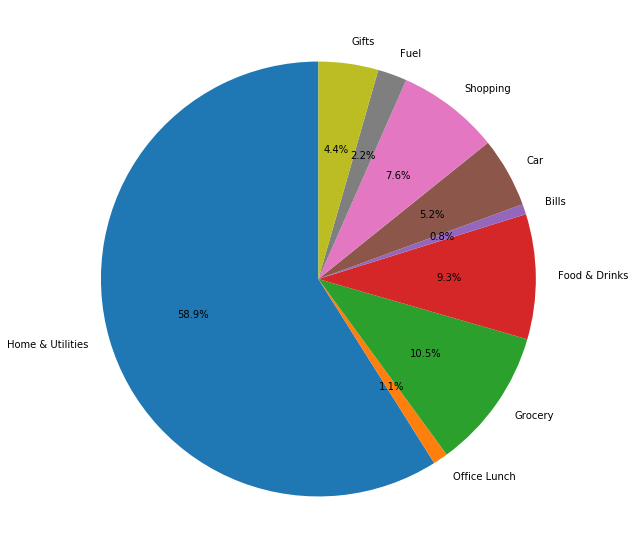

In [12]:
plt.figure(figsize=[10,10])
_ = plt.pie(df_expense.Amount,labels=df_expense.index,shadow=False, startangle=90,autopct='%1.1f%%')

In [13]:
show(fin.plot_expense(df_expense))

# Amount available for investment

In [14]:
salary_take_home = salary
salary_take_home

4513.56

In [15]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $275.84


In [16]:
storage = salary_take_home - df_expense.Amount.sum()
guilt_free_money = 0.1*storage
storage = storage - guilt_free_money
invest_perc = 100*storage/salary_take_home

print(f"Amount available for guilt free expenditure : ${guilt_free_money:.2f}")
print(f"Amount available for investment : ${storage:.2f} {invest_perc:.2f}%")

Amount available for guilt free expenditure : $197.14
Amount available for investment : $1774.26 39.31%


In [18]:
df_goal = pd.read_csv("model_goal_allocation.csv",index_col='goal',usecols=['goal','model_investment'])
df_goal['asset_ratio'] = df_goal.model_investment / df_goal.model_investment.sum()
df_goal['actual_investment'] = df_goal.asset_ratio * storage
df_goal['delta'] = df_goal.actual_investment - df_goal.model_investment
df_goal

,model_investment,asset_ratio,actual_investment,delta
goal,,,,
home,1550.693801,0.507803,900.974255,-649.719547
vacation,234.204323,0.076694,136.075907,-98.128416
wedding,377.733955,0.123696,219.468581,-158.265374
retirement,891.100000,0.291807,517.741257,-373.358743


In [19]:
df_report = pd.concat([df_expense.Amount,df_goal.actual_investment])

In [20]:
df_report = df_report.append(pd.Series([guilt_free_money],index=['Guilt Free']))

In [21]:
df_report = df_report.to_frame(name='value')
df_report['percentage'] = 100*df_report.value/df_report.value.sum()
df_report["model_value"] = pd.concat([df_expense.budget , df_goal.model_investment])
df_report.fillna(0,inplace=True)
df_report

,value,percentage,model_value
Home & Utilities,1498.280000,33.195083,1565.000000
Office Lunch,28.090000,0.622347,200.000000
Grocery,266.570000,5.905981,250.000000
Food & Drinks,236.170000,5.232455,230.000000
Bills,19.500000,0.432031,150.000000
Car,131.870000,2.921641,143.000000
Shopping,193.520000,4.287525,100.000000
Fuel,55.190000,1.222760,130.000000
Gifts,112.970000,2.502902,50.000000
home,900.974255,19.961499,1550.693801


In [22]:
df_report

,value,percentage,model_value
Home & Utilities,1498.280000,33.195083,1565.000000
Office Lunch,28.090000,0.622347,200.000000
Grocery,266.570000,5.905981,250.000000
Food & Drinks,236.170000,5.232455,230.000000
Bills,19.500000,0.432031,150.000000
Car,131.870000,2.921641,143.000000
Shopping,193.520000,4.287525,100.000000
Fuel,55.190000,1.222760,130.000000
Gifts,112.970000,2.502902,50.000000
home,900.974255,19.961499,1550.693801


In [23]:
df_report.sum()

value          4513.560000
percentage      100.000000
model_value    5871.732079
dtype: float64

In [24]:
df_report.to_csv('report_october_2020.csv')